# Representation Gaps in Florida High School Science Ernollment  
## Data sources  
From the [Florida Department of Education](http://www.fldoe.org/accountability/data-sys/edu-info-accountability-services/pk-12-public-school-data-pubs-reports/students.stml):  
- FedGradRateRace1819.xls  
- FedGradRateCategory1819.xls  
- 1819CompletersStateDistrict.xlsx  
- a PERA data request for 1819 course enrollment w/demographic breakdown

## Data Preparation

In [1]:
# read in the libraries and functions used in this analysis
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import patsy

In [2]:
# some general settings
alpha = .05                                 # set alpha for hypothesis tests
colors = ['#4fb451','#4784fd','#dec828']    # colors for biology, chemistry, and physics
area = ['biology','chemistry','physics']    # when they're needed in a list, mostly as loop iterables
diffs = ['diff_F','diff_NW','diff_FRPL']    # when they're needed in a list, mostly as loop iterables
sns.set(style="whitegrid")                  # plot styling

# get data on enrollment and district demographics
district_info = pd.read_csv('./data/district_info.csv')
enrollment = pd.read_csv('./data/1819-enrollment-demographics.csv')

# create categories for course areas
physics = ["2003380","2003385","2003390","2003410","2003421","2003422","2003425","2003430","2003431","2003432","2003433","2003836","2003840","2003845","2003850","2003855"]
chemistry = ["2003340","2003345","2003350","2003360","2003370","2003371","2003372","2003373","2003800","2003805","2003810","2003820","2003830"]
biology = ["2000310","2000315","2000320","2000321","2000322","2000323","2000330","2000335","2000340","2000800","2000805","2000810","2000820","2000850"]

# add column for course area
enrollment['area'] = "elective"
enrollment.loc[enrollment['course_number'].isin(biology) == True, 'area'] = "biology"
enrollment.loc[enrollment['course_number'].isin(chemistry) == True, 'area'] = "chemistry"
enrollment.loc[enrollment['course_number'].isin(physics) == True, 'area'] = "physics"

# clean up
enrollment = enrollment.drop(columns=['course_number','course_name'])

# group by course area
grouped = enrollment.sort_values(by='district').groupby(by=['district','area']).sum().reset_index()

# add columns with senior class demographics
districts = district_info[['district','district_FRPL', 'district_NW', 'district_grads']].sort_values(by='district').drop_duplicates()
data = grouped.merge(districts,on='district',how='left')
data['taking_rate'] = data['enrolled'] / data['district_grads']

# remove non-districts
non_districts = ['FL VIRTUAL','DEAF/BLIND']
data = data.loc[(data['district'].isin(non_districts) == False) & (data['area'] != "elective")]

# diff_X is percentage point difference between course area enrollment and district average enrollment
data['diff_NW'] = ((data['takers_NW'] / data['enrolled']) - data['district_NW']) *100
data['diff_FRPL'] = ((data['takers_FRPL'] / data['enrolled']) - data['district_FRPL']) *100
data['diff_F'] = ((data['takers_F'] / data['enrolled']) - .5) *100
data.fillna(0, inplace=True)

# clean up
data = data[['district', 'district_FRPL', 'district_NW', 'district_grads', 'area', 'taking_rate', 'diff_NW', 'diff_FRPL', 'diff_F']]

In [3]:
data.head(9)

,district,district_FRPL,district_NW,district_grads,area,taking_rate,diff_NW,diff_FRPL,diff_F
0,ALACHUA,0.3733,0.4986,1843,biology,1.233315,4.957422,0.373476,0.505939
1,ALACHUA,0.3733,0.4986,1843,chemistry,0.575692,-2.169142,-14.992582,1.272385
3,ALACHUA,0.3733,0.4986,1843,physics,0.149213,-5.860000,-24.966364,-16.909091
4,BAKER,0.4551,0.1462,301,biology,1.209302,1.314066,-1.004505,4.945055
5,BAKER,0.4551,0.1462,301,chemistry,0.617940,-1.179140,-22.391720,3.763441
7,BAKER,0.4551,0.1462,301,physics,0.156146,-10.364681,-22.105745,7.446809
8,BAY,0.3817,0.2839,1483,biology,1.072151,-1.912013,15.100440,1.572327
9,BAY,0.3817,0.2839,1483,chemistry,0.523938,-1.491673,9.706448,2.638353
11,BAY,0.3817,0.2839,1483,physics,0.339852,0.975079,12.425238,-2.777778


In [4]:
data.iloc[:,:-3].describe()

,district_FRPL,district_NW,district_grads,taking_rate
count,195.000000,195.000000,195.000000,195.000000
mean,0.480317,0.438613,2810.051282,0.690807
std,0.122648,0.207741,4439.901429,0.477804
min,0.139200,0.111700,32.000000,0.000000
25%,0.406250,0.283900,233.500000,0.237889
50%,0.471300,0.404400,985.000000,0.627946
75%,0.552200,0.567600,3010.000000,1.185059
max,0.928600,1.000000,23303.000000,1.716667


In [5]:
# drop na values from diff_X analyses
diff_data = data.loc[data['taking_rate'] != 0]
diff_data.iloc[:,-3:].describe()

,diff_NW,diff_FRPL,diff_F
count,188.000000,188.000000,188.000000
mean,-1.478637,-5.364959,-1.711547
std,6.524309,13.292301,7.862768
min,-18.567391,-39.990000,-30.000000
25%,-5.592839,-13.707364,-3.999519
50%,-0.379127,-5.165888,0.121624
75%,2.347354,2.169473,2.647810
max,21.313939,37.140000,19.354839


In [6]:
listy = []
for i in data['district'].drop_duplicates().to_list():
    var = 0
    for j in data.loc[data['area'] == 'physics']['district'].drop_duplicates().to_list():
        if i == j:
            var = 1
        else:
            continue
    if var == 0:
        listy.append(i)
data.loc[data['district'].isin(listy) == True]['district'].drop_duplicates().shape

(17,)

biology      71
chemistry    70
physics      54
Name: area, dtype: int64


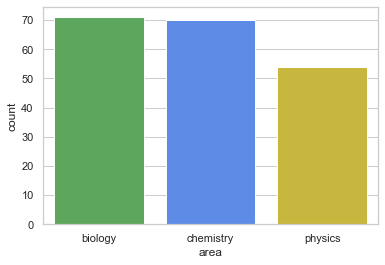

In [7]:
print(data['area'].value_counts())
sns.countplot(x=data['area'], palette=colors);

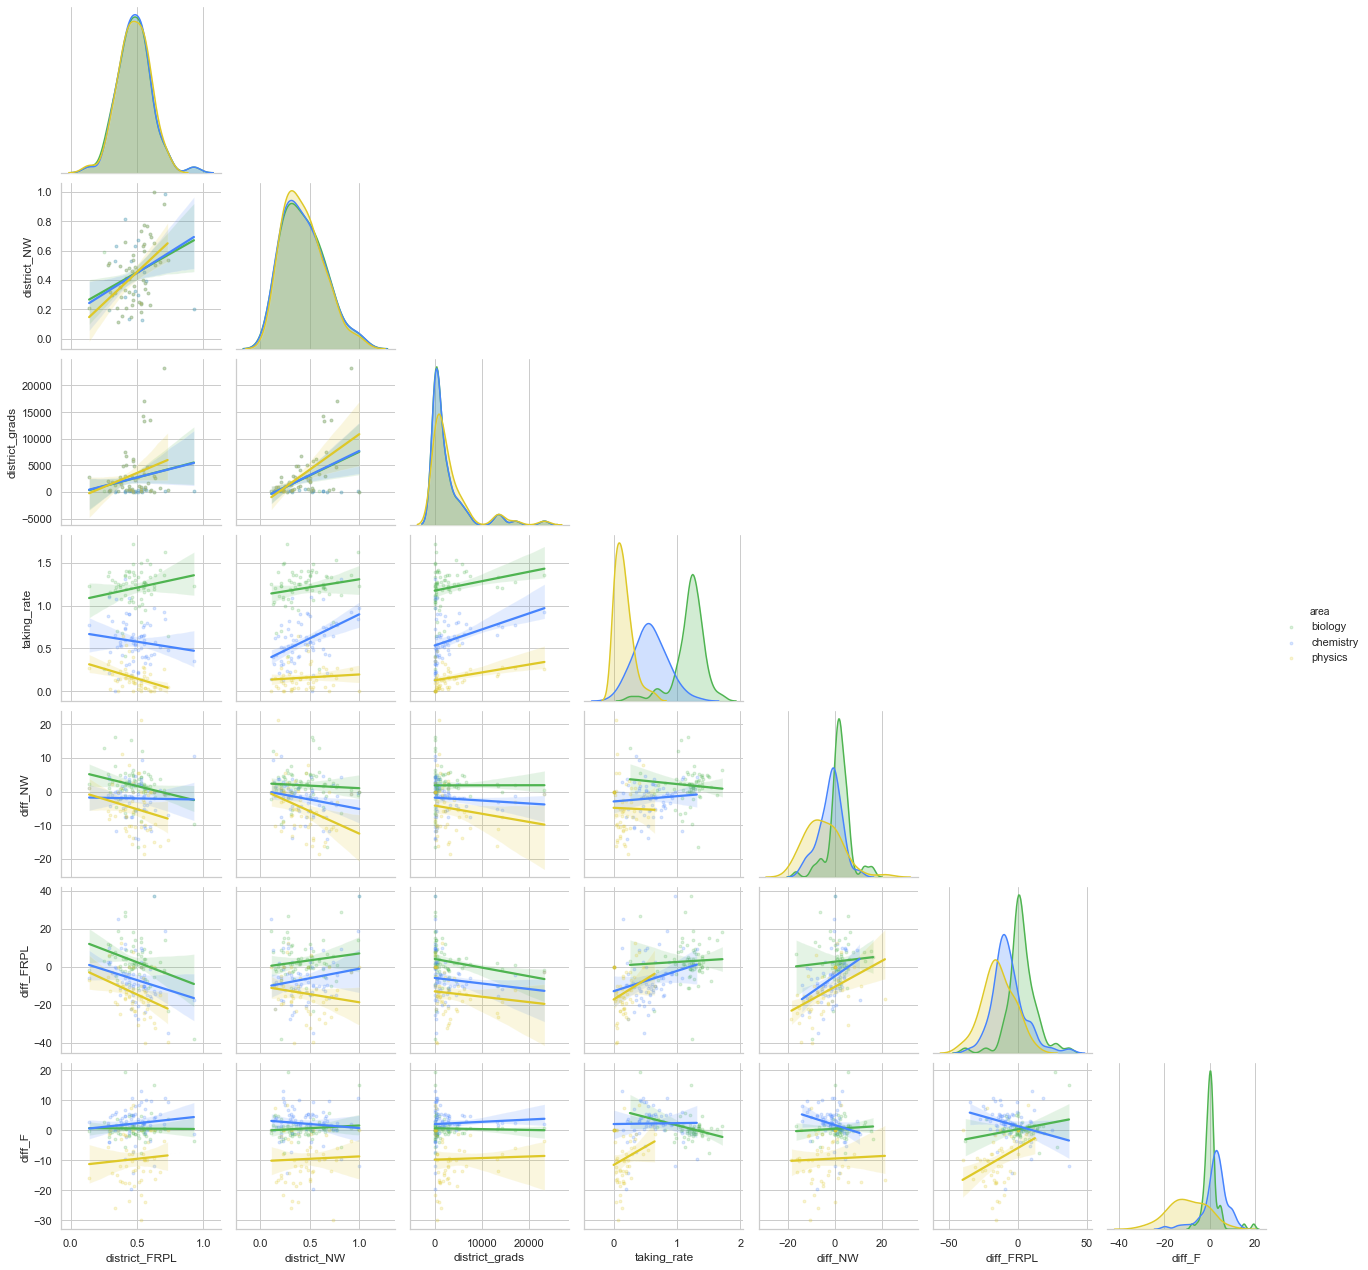

In [8]:
sns.pairplot(data, corner=True, kind='reg', hue='area', palette=colors, \
             plot_kws={'scatter_kws': {'alpha': 0.2, 's':8}});

In [9]:
# Pearson's r coefficiet to ID significant relationships

# loop over each combniation of factors
for i in area:
    statsdata = diff_data.loc[data['area'] == i]
    if i == "biology":                         # not looking at factors affecting biology enrollment
        continue
    print("\n",i)
    for x in ['taking_rate','district_grads','district_NW','district_FRPL']:
        for y in ['taking_rate','diff_F','diff_NW','diff_FRPL']:
            if x == y:
                continue                                                     # omit self-interactions
            pearson = sp.stats.pearsonr(statsdata[x], statsdata[y])          # calculate Pearson's r for factor pair
            r, p = round(pearson[0],3), round(pearson[1],3)                  # store rounded r and p-values
            if np.abs(r) > 0:                                                # omit small r-values
                if p <= alpha:                                               # omit non-significant combinations
                    print("r =", r, "\tp =", p,"\t",y, "\tvs.", x)
print("\nTo investigate further:\n rate vs. dist_NW, dist_grads, dist_FRPL\n diff_X vs. dist_NW, dist_FRPL")


 chemistry
r = 0.259 	p = 0.031 	 diff_FRPL 	vs. taking_rate
r = 0.311 	p = 0.009 	 taking_rate 	vs. district_grads
r = 0.498 	p = 0.0 	 taking_rate 	vs. district_NW
r = -0.244 	p = 0.043 	 diff_NW 	vs. district_NW

 physics
r = 0.447 	p = 0.001 	 diff_F 	vs. taking_rate
r = 0.531 	p = 0.0 	 diff_FRPL 	vs. taking_rate
r = -0.423 	p = 0.003 	 diff_NW 	vs. district_NW
r = -0.359 	p = 0.012 	 taking_rate 	vs. district_FRPL
r = -0.471 	p = 0.001 	 diff_FRPL 	vs. district_FRPL

To investigate further:
 rate vs. dist_NW, dist_grads, dist_FRPL
 diff_X vs. dist_NW, dist_FRPL


## Chem and Physics rates are low

In [10]:
bio = data.loc[data['area'] == "biology"]
chem = data.loc[data['area'] == "chemistry"]
phy = data.loc[data['area'] == "physics"]

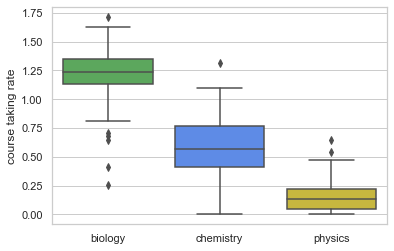

In [11]:
sns.boxplot(x='area', y='taking_rate', data=data, palette=colors)
plt.xlabel("")
plt.ylabel("course taking rate");

In [12]:
# mean taking rates
b = bio.taking_rate.mean()
c = chem.taking_rate.mean()
p = phy.taking_rate.mean()
print("bio:", np.round(b,3))
print("chem:", np.round(c,3))
print("phys:", np.round(p,3))

bio: 1.201
chem: 0.583
phys: 0.159


In [13]:
# normality
b = sp.stats.shapiro(bio.taking_rate)
c = sp.stats.shapiro(chem.taking_rate)
p = sp.stats.shapiro(phy.taking_rate)
print("bio:", np.round(b[1],3))
print("chem:", np.round(c[1],3))
print("phys:", np.round(p[1],3))
print("n>>30 so we can still use a ttest")

bio: 0.0
chem: 0.911
phys: 0.0
n>>30 so we can still use a ttest


In [14]:
# equal variances
bc = sp.stats.levene(bio.taking_rate,chem.taking_rate)
cp = sp.stats.levene(chem.taking_rate,phy.taking_rate)
bp = sp.stats.levene(bio.taking_rate,phy.taking_rate)
print("bio:chem", np.round(bc[1],3))
print("chem:phys", np.round(cp[1],3), "... violated,")
print("bio:phys", np.round(bp[1],3), "... almost violated")

bio:chem 0.161
chem:phys 0.0 ... violated,
bio:phys 0.053 ... almost violated


In [15]:
# Welch's ttest since sample sizes are unequal, and variances are unequal for 1 pair
bc = sp.stats.ttest_ind(bio.taking_rate,chem.taking_rate, equal_var=False) # equal_var set to "False" runs Welch's
cp = sp.stats.ttest_ind(chem.taking_rate,phy.taking_rate, equal_var=False)
bp = sp.stats.ttest_ind(bio.taking_rate,phy.taking_rate, equal_var=False)
print("bio:chem", np.round(bc[1],3))
print("chem:phys", np.round(cp[1],3))
print("bio:phys", np.round(bp[1],3))
print("They're significantly different: bio > chem > phy")

bio:chem 0.0
chem:phys 0.0
bio:phys 0.0
They're significantly different: bio > chem > phy


In [16]:
# notable districts
data.loc[data['area'] == 'chemistry'].sort_values(by='taking_rate', ascending=False).head(10)

,district,district_FRPL,district_NW,district_grads,area,taking_rate,diff_NW,diff_FRPL,diff_F
133,JEFFERSON,0.4063,0.8125,32,chemistry,1.312500,4.464286,9.370000,-9.523810
250,UF LAB SCH,0.2913,0.5146,103,chemistry,1.097087,4.292212,9.808053,-3.982301
239,SUMTER,0.4387,0.3161,465,chemistry,1.086022,3.835545,-5.850198,-0.891089
83,FSU LAB SCH,0.3451,0.6338,142,chemistry,1.077465,-11.746013,-0.523072,6.209150
65,FAMU LAB SCH,0.6286,1.0000,35,chemistry,0.971429,0.000000,37.140000,-11.764706
172,MIAMI-DADE,0.7066,0.9195,23303,chemistry,0.925160,-0.702725,-2.669833,2.010761
227,SEMINOLE,0.4194,0.4671,5076,chemistry,0.915091,-1.909139,-3.812982,1.926803
126,INDIAN RIVER,0.4420,0.4044,1172,chemistry,0.901877,-1.177938,-3.991864,1.655629
176,MONROE,0.4371,0.4816,517,chemistry,0.895551,-3.451577,-7.856868,5.507559
147,LEON,0.2796,0.5012,2139,chemistry,0.873773,-1.163339,2.430583,2.487961


In [17]:
# notable districts
data.loc[data['area'] == 'physics'].sort_values(by='taking_rate', ascending=False).head(10)

,district,district_FRPL,district_NW,district_grads,area,taking_rate,diff_NW,diff_FRPL,diff_F
19,BREVARD,0.3968,0.3859,4942,physics,0.646499,-5.413161,-10.290329,-1.267606
229,SEMINOLE,0.4194,0.4671,5076,physics,0.545114,-7.533997,-13.316943,-6.451030
178,MONROE,0.4371,0.4816,517,physics,0.468085,8.038347,0.091653,-7.851240
81,FRANKLIN,0.4667,0.2667,60,physics,0.400000,2.496667,7.496667,8.333333
252,UF LAB SCH,0.2913,0.5146,103,physics,0.359223,-8.216757,6.005135,-1.351351
11,BAY,0.3817,0.2839,1483,physics,0.339852,0.975079,12.425238,-2.777778
149,LEON,0.2796,0.5012,2139,physics,0.317906,-5.708235,-5.165882,-5.441176
120,HILLSBOROUGH,0.5420,0.6345,14231,physics,0.288595,-7.642841,-18.553543,-7.852447
23,BROWARD,0.5516,0.7758,17144,physics,0.276890,-3.154047,-12.080160,-5.951127
233,ST. JOHNS,0.1392,0.2107,2895,physics,0.273921,1.124199,-6.732106,-15.825977


## Clues to increasing taking rates

In [18]:
# Pearson's r coefficiet to ID significant relationships

# loop over each combniation of factors
for i in area:
    statsdata = data.loc[data['area'] == i]
    if i == "biology":                         # not looking at factors affecting biology enrollment
        continue
    print("\n",i)
    for x in ['district_grads','district_NW','district_FRPL']:
        for y in ['taking_rate']:
            pearson = sp.stats.pearsonr(statsdata[x], statsdata[y])          # calculate Pearson's r for factor pair
            r, p = round(pearson[0],3), round(pearson[1],3)                  # store rounded r and p-values
            if np.abs(r) > 0:                                                # omit small r-values
                if p <= alpha:                                               # omit non-significant combinations
                    print("r =", r, "\tp =", p,"\t",y, "\tvs.", x)


 chemistry
r = 0.318 	p = 0.007 	 taking_rate 	vs. district_grads
r = 0.464 	p = 0.0 	 taking_rate 	vs. district_NW

 physics
r = 0.306 	p = 0.024 	 taking_rate 	vs. district_grads
r = -0.377 	p = 0.005 	 taking_rate 	vs. district_FRPL


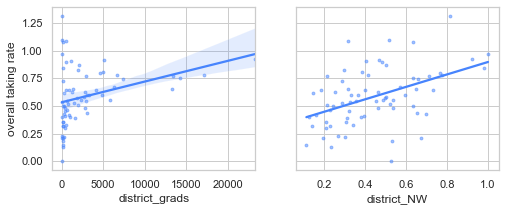

In [19]:
# chemsitry taking rate plots

fig, ax = plt.subplots(1,2, figsize=(8,3), sharey=True)
#fig.subplots_adjust(wspace=.1, hspace=.5)
plotdata = data.loc[data['area'] == 'chemistry']
sns.regplot(x='district_grads', y='taking_rate', data=plotdata, color=colors[1], scatter_kws={'alpha':.5, 's':8}, ax=ax[0])
sns.regplot(x='district_NW', y='taking_rate', data=plotdata, ci=None, color=colors[1], scatter_kws={'alpha':.5, 's':8}, ax=ax[1])
ax[0].set(ylabel="overall taking rate")
ax[1].set(ylabel="")
plt.show()

                            OLS Regression Results                            
Dep. Variable:            taking_rate   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     7.850
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           0.000148
Time:                        16:27:27   Log-Likelihood:                 7.2529
No. Observations:                  70   AIC:                            -6.506
Df Residuals:                      66   BIC:                             2.488
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

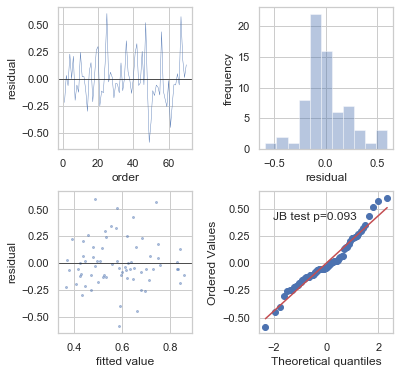

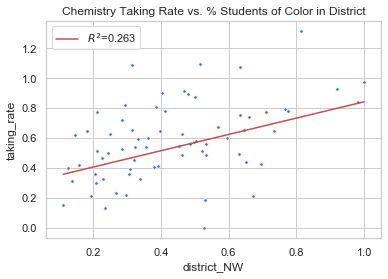

In [20]:
# chemistry lin reg
plotdata = data.loc[data['area'] == 'chemistry'].sort_values(by='district_NW')
g = 'taking_rate ~ (district_grads + district_NW)**2'   # patsy formula with interaction term
#g = 'taking_rate ~ district_NW'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
chemistry_r2 = np.round(model.rsquared,3)
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

plt.plot(plotdata['district_NW'], model.params[0]+model.params[2]*plotdata['district_NW'], color='r', ls="-", label="$R^2$=" + str(np.round(model.rsquared,3))) # regression curve
sns.scatterplot(plotdata['district_NW'], plotdata['taking_rate'], s=12, alpha=1) # plot raw data
plt.title('Chemistry Taking Rate vs. % Students of Color in District')
plt.show()

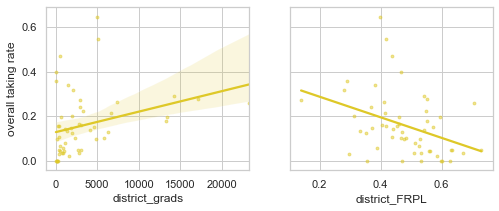

In [21]:
# physics taking rate plots

fig, ax = plt.subplots(1,2, figsize=(8,3), sharey=True)
#fig.subplots_adjust(wspace=.1, hspace=.5)
plotdata = data.loc[data['area'] == 'physics']
sns.regplot(x='district_grads', y='taking_rate', data=plotdata, color=colors[2], scatter_kws={'alpha':.5, 's':8}, ax=ax[0])
sns.regplot(x='district_FRPL', y='taking_rate', data=plotdata, color=colors[2], ci=None, scatter_kws={'alpha':.5, 's':8}, ax=ax[1])
ax[0].set(ylabel="overall taking rate")
ax[1].set(ylabel="")
plt.show()

                            OLS Regression Results                            
Dep. Variable:            taking_rate   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     8.108
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           0.000169
Time:                        16:27:28   Log-Likelihood:                 40.124
No. Observations:                  54   AIC:                            -72.25
Df Residuals:                      50   BIC:                            -64.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

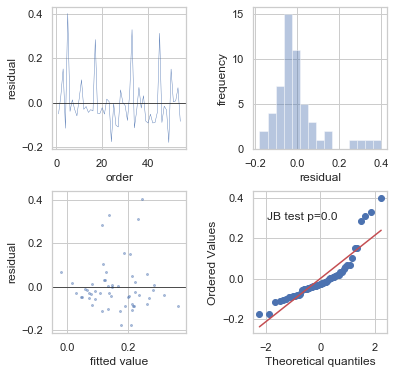

In [22]:
# physics lin reg
plotdata = data.loc[data['area'] == 'physics']
g = 'taking_rate ~ (district_grads + district_FRPL)**2'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:            taking_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     8.632
Date:                Sun, 19 Apr 2020   Prob (F-statistic):            0.00491
Time:                        16:27:29   Log-Likelihood:                 33.567
No. Observations:                  54   AIC:                            -63.13
Df Residuals:                      52   BIC:                            -59.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3794      0.077      4.925

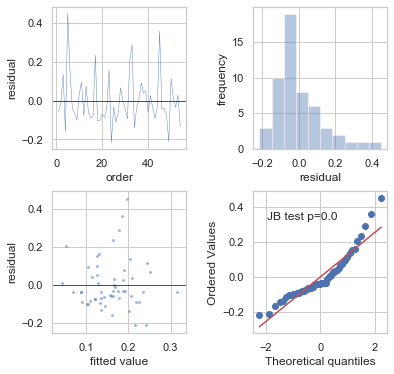

In [23]:
# physics lin reg - single variable
plotdata = data.loc[(data['area'] == 'physics')]
g = 'taking_rate ~ district_FRPL'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:             rate_trans   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     9.482
Date:                Sun, 19 Apr 2020   Prob (F-statistic):            0.00331
Time:                        16:27:29   Log-Likelihood:                 17.460
No. Observations:                  54   AIC:                            -30.92
Df Residuals:                      52   BIC:                            -26.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6616      0.104      6.374

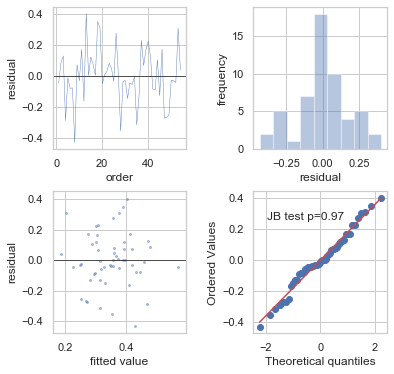

In [24]:
# square root transformation - physics lin reg - single variable
plotdata = data.loc[data['area'] == 'physics'].copy().sort_values(by='district_FRPL')
plotdata['rate_trans'] = plotdata['taking_rate']**.5
#g = 'rate_trans ~ (district_grads + district_FRPL)**2'   # patsy formula with interaction term
g = 'rate_trans ~ district_FRPL'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
physics_r2 = np.round(model.rsquared,3)
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

## Clues for addressing underrepresentation

In [25]:
# Pearson's r coefficiet to ID significant relationships

# loop over each combniation of factors
for i in area:
    statsdata = diff_data.loc[data['area'] == i]
    if i == "biology":                         # not looking at factors affecting biology enrollment
        continue
    print("\n",i)
    for x in ['district_grads','district_NW','district_FRPL', 'taking_rate']:
        for y in ['diff_NW','diff_F','diff_FRPL']:
            pearson = sp.stats.pearsonr(statsdata[x], statsdata[y])          # calculate Pearson's r for factor pair
            r, p = round(pearson[0],3), round(pearson[1],3)                  # store rounded r and p-values
            if np.abs(r) > 0:                                                # omit small r-values
                if p <= alpha:                                               # omit non-significant combinations
                    print("r =", r, "\tp =", p,"\t",y, "\tvs.", x)


 chemistry
r = -0.244 	p = 0.043 	 diff_NW 	vs. district_NW
r = 0.259 	p = 0.031 	 diff_FRPL 	vs. taking_rate

 physics
r = -0.423 	p = 0.003 	 diff_NW 	vs. district_NW
r = -0.471 	p = 0.001 	 diff_FRPL 	vs. district_FRPL
r = 0.447 	p = 0.001 	 diff_F 	vs. taking_rate
r = 0.531 	p = 0.0 	 diff_FRPL 	vs. taking_rate


                            OLS Regression Results                            
Dep. Variable:                diff_NW   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4.237
Date:                Sun, 19 Apr 2020   Prob (F-statistic):             0.0435
Time:                        16:27:30   Log-Likelihood:                -205.88
No. Observations:                  69   AIC:                             415.8
Df Residuals:                      67   BIC:                             420.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4370      1.342      0.326      

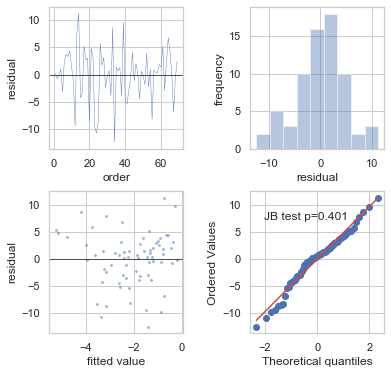

In [26]:
plotdata = diff_data.loc[data['area'] == 'chemistry']
g = 'diff_NW ~ district_NW'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:              diff_FRPL   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4.829
Date:                Sun, 19 Apr 2020   Prob (F-statistic):             0.0315
Time:                        16:27:31   Log-Likelihood:                -266.03
No. Observations:                  69   AIC:                             536.1
Df Residuals:                      67   BIC:                             540.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -14.1298      3.637     -3.885      

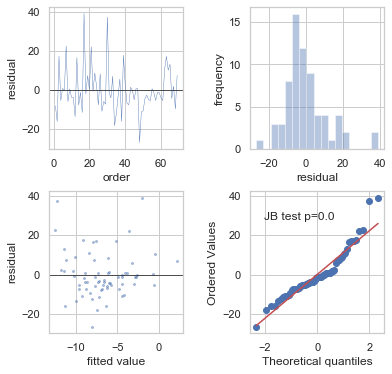

In [27]:
plotdata = diff_data.loc[data['area'] == 'chemistry']
g = 'diff_FRPL ~ taking_rate'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:                diff_NW   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     10.03
Date:                Sun, 19 Apr 2020   Prob (F-statistic):            0.00273
Time:                        16:27:31   Log-Likelihood:                -161.94
No. Observations:                  48   AIC:                             327.9
Df Residuals:                      46   BIC:                             331.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.3659      2.720      0.870      

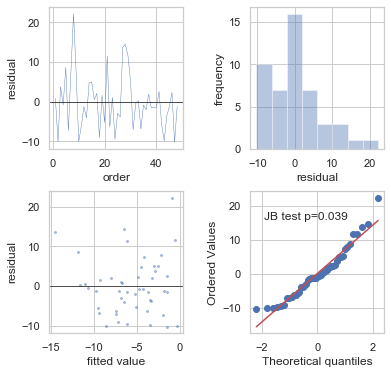

In [28]:
# physics
plotdata = diff_data.loc[data['area'] == 'physics']
g = 'diff_NW ~ district_NW'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:              diff_FRPL   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     13.08
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           0.000738
Time:                        16:27:32   Log-Likelihood:                -175.94
No. Observations:                  48   AIC:                             355.9
Df Residuals:                      46   BIC:                             359.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.9196      5.848      0.841

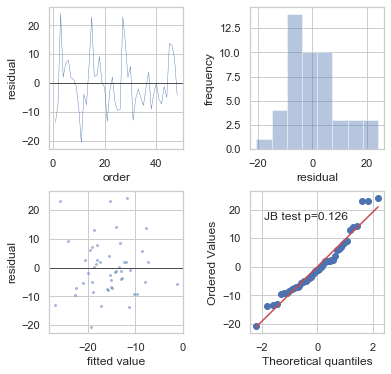

In [29]:
# no significant trends in the 3 diffs
plotdata = diff_data.loc[data['area'] == 'physics']
g = 'diff_FRPL ~ district_FRPL'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:                 diff_F   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     11.48
Date:                Sun, 19 Apr 2020   Prob (F-statistic):            0.00145
Time:                        16:27:33   Log-Likelihood:                -162.27
No. Observations:                  48   AIC:                             328.5
Df Residuals:                      46   BIC:                             332.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -15.4946      1.732     -8.945      

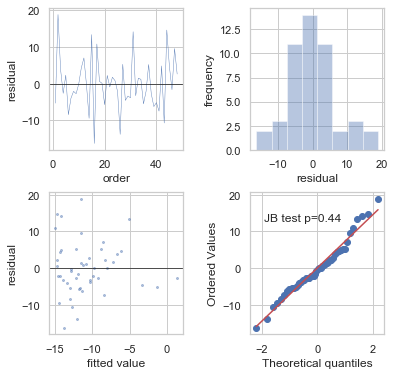

In [30]:
# no significant trends in the 3 diffs
plotdata = diff_data.loc[data['area'] == 'physics']
g = 'diff_F ~ taking_rate'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:              diff_FRPL   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     18.02
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           0.000105
Time:                        16:27:33   Log-Likelihood:                -174.01
No. Observations:                  48   AIC:                             352.0
Df Residuals:                      46   BIC:                             355.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -23.0981      2.212    -10.440      

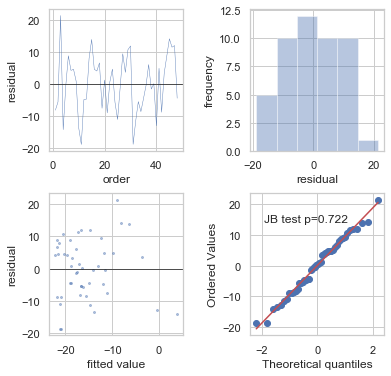

In [31]:
# no significant trends in the 3 diffs
plotdata = diff_data.loc[data['area'] == 'physics']
g = 'diff_FRPL ~ taking_rate'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

# Interaction of diff_X factors

                            OLS Regression Results                            
Dep. Variable:                diff_NW   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     9.664
Date:                Sun, 19 Apr 2020   Prob (F-statistic):            0.00276
Time:                        16:27:34   Log-Likelihood:                -203.35
No. Observations:                  69   AIC:                             410.7
Df Residuals:                      67   BIC:                             415.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0510      0.648     -1.621      0.1

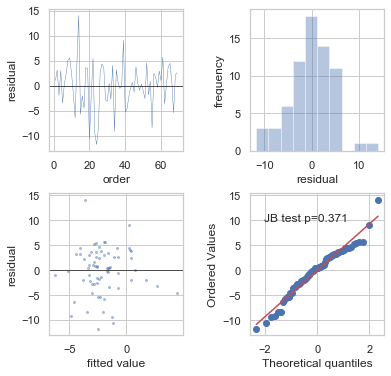

In [32]:
# diff_NW vs diff_FRPL
plotdata = diff_data.loc[data['area'] == 'chemistry']
g = 'diff_NW ~ diff_FRPL'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

                            OLS Regression Results                            
Dep. Variable:                diff_NW   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     9.012
Date:                Sun, 19 Apr 2020   Prob (F-statistic):            0.00432
Time:                        16:27:35   Log-Likelihood:                -162.39
No. Observations:                  48   AIC:                             328.8
Df Residuals:                      46   BIC:                             332.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9937      1.858     -0.535      0.5

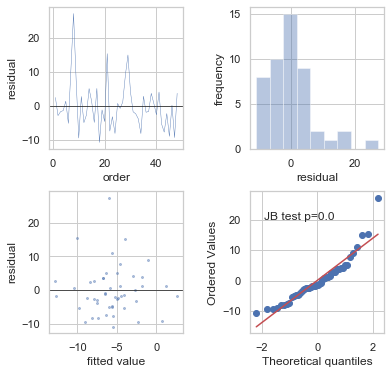

In [33]:
# diff_NW vs diff_FRPL
plotdata = diff_data.loc[data['area'] == 'physics']
g = 'diff_NW ~ diff_FRPL'   # patsy formula with interaction term
model = ols(formula=g, data=plotdata).fit()             # create model
print(model.summary())

# prepare residual plots
fig, ax = plt.subplots(2,2, figsize=(6,6))
#titles = ["Full Model (92 terms)","Backward Selection (62 terms)", "Backward Selection (30 terms)"]  # plot titles
plt.subplots_adjust(wspace=.5, hspace=.3)                                         # subplot formatting

#print(model.summary())

# 4 residual plots for each regression model
sns.lineplot(x=np.arange(1,plotdata.shape[0]+1), y=model.resid, linewidth=.4, ax=ax[0,0])  # res vs order
ax[0,0].set(xlabel="order", ylabel="residual")                              # add labels
ax[0,0].axhline(linewidth=.7, color='k')                                    # add x=0 line

ax[1,0].scatter(model.fittedvalues, model.resid, alpha=.4, s=4)             # res vs fitted values
ax[1,0].axhline(linewidth=.7, color='k')                                    # add x=0 line
ax[1,0].set(xlabel="fitted value", ylabel="residual")                       # add labels

sns.distplot(model.resid, kde=False, ax=ax[0,1])                            # histogram of res
ax[0,1].set(xlabel="residual", ylabel="frequency")                          # add labels

sp.stats.probplot(model.resid, plot=ax[1,1])                                # res probability plot
JB = "JB test p=" + str(np.round(sm.stats.stattools.jarque_bera(model.resid)[1],3))  # JB test p-value
ax[1,1].text(.1,.8,JB, transform=ax[1,1].transAxes)                         # add textbox
ax[1,1].set(title="")                                                       # add title

plt.show()

# Simple means of diff_X, identifying outliers

In [34]:
bio = diff_data.loc[diff_data['area'] == "biology"]
chem = diff_data.loc[diff_data['area'] == "chemistry"]
phy = diff_data.loc[diff_data['area'] == "physics"]

In [35]:
# mean diff_X (under or over representation)
for i in diffs:
    print(i,"mean")
    c = chem[i].mean()
    p = phy[i].mean()
    print("chem:", np.round(c,3))
    print("phys:", np.round(p,3))
    print("\n")

diff_F mean
chem: 2.271
phys: -10.823


diff_NW mean
chem: -2.049
phys: -5.594


diff_FRPL mean
chem: -6.751
phys: -15.622




In [36]:
# normality
for i in diffs:
    print(i,"SW test")
    c = sp.stats.shapiro(chem[i])
    p = sp.stats.shapiro(phy[i])
    print("chem:", np.round(c[1],3))
    print("phys:", np.round(p[1],3))
    print("\n")

print("n > 30 so we can still use a ttest")

diff_F SW test
chem: 0.0
phys: 0.893


diff_NW SW test
chem: 0.116
phys: 0.023


diff_FRPL SW test
chem: 0.003
phys: 0.591


n > 30 so we can still use a ttest


In [37]:
# one-sample t-test
print("Are means different from zero?\n")
for i in diffs:
    print(i)
    c = sp.stats.ttest_1samp(chem[i],0)
    p = sp.stats.ttest_1samp(phy[i],0)
    print("chemistry (mean=",np.round(chem[i].mean(),3),"percentage points) p-value:", np.round(c[1],3))
    print("physics (mean=",np.round(phy[i].mean(),3),"percentage points) p-value:", np.round(p[1],3))
    print("\n")

Are means different from zero?

diff_F
chemistry (mean= 2.271 percentage points) p-value: 0.001
physics (mean= -10.823 percentage points) p-value: 0.0


diff_NW
chemistry (mean= -2.049 percentage points) p-value: 0.001
physics (mean= -5.594 percentage points) p-value: 0.0


diff_FRPL
chemistry (mean= -6.751 percentage points) p-value: 0.0
physics (mean= -15.622 percentage points) p-value: 0.0




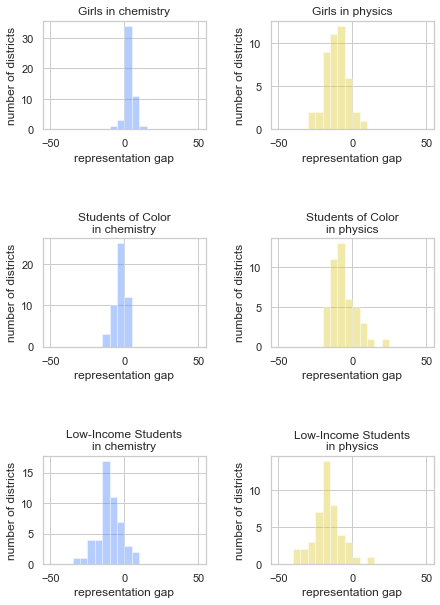

In [38]:
fig, ax = plt.subplots(3,2, figsize=(7,10), sharey=False, sharex=False)
fig.subplots_adjust(wspace=.4, hspace=1)
titles = ['Girls in ','Students of Color\nin ', 'Low-Income Students\nin ']
for i in [0,1]:                               # loop over each area
    plotdata = diff_data.loc[(diff_data['area'] == area[i+1]) & (diff_data['district_grads'] > 233)]
    for j in [0,1,2]:                           # loop over each diff_X
        sns.distplot(plotdata[diffs[j]], color=colors[i+1], bins=20, kde=False, ax=ax[j,i], hist_kws={'range':(-50,50)})
        ax[j,i].set(ylabel='number of districts',xlabel='representation gap', title=titles[j]+area[i+1])
plt.show()

In [39]:
data[['district','district_grads']].drop_duplicates().sort_values(by='district_grads').tail(10)

,district,district_grads
226,SEMINOLE,5076
142,LEE,5778
211,POLK,6283
207,PINELLAS,6723
56,DUVAL,7420
199,PALM BEACH,13313
191,ORANGE,13438
117,HILLSBOROUGH,14231
20,BROWARD,17144
171,MIAMI-DADE,23303


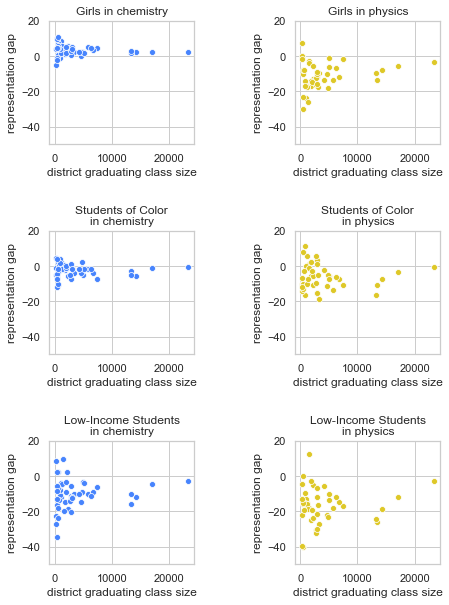

In [40]:
fig, ax = plt.subplots(3,2, figsize=(7,10), sharey=False, sharex=False)
fig.subplots_adjust(wspace=.7, hspace=.7)
titles = ['Girls in ','Students of Color\nin ', 'Low-Income Students\nin ']
for i in [0,1]:                               # loop over each area
    plotdata = diff_data.loc[(diff_data['area'] == area[i+1]) & (diff_data['district_grads'] > 233)]
    for j in [0,1,2]:                           # loop over each diff_X
        sns.scatterplot(x='district_grads', y=diffs[j], data=plotdata, color=colors[i+1], ax=ax[j,i])
        ax[j,i].set(xlabel='district graduating class size',ylabel='representation gap', title=titles[j]+area[i+1])
        ax[j,i].set_ylim(-50,20)
plt.show()

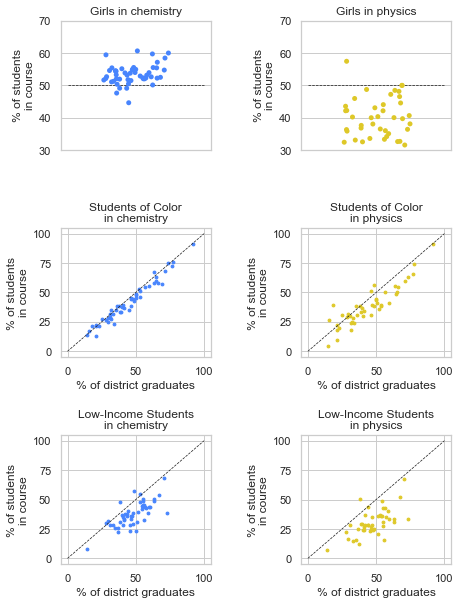

In [41]:
fig, ax = plt.subplots(3,2, figsize=(7,10))
fig.subplots_adjust(wspace=.6, hspace=.6)
titles = ['Girls in ','Students of Color\nin ', 'Low-Income Students\nin ']
dists = ['district_NW','district_FRPL']
for i in [0,1]:                               # loop over each area
    plotdata = diff_data.loc[(diff_data['area'] == area[i+1]) & (diff_data['district_grads'] > 233)]
    for j in [0,1,2]:                           # loop over each diff_X
        if j == 0:
            sns.stripplot(y=50+plotdata['diff_F'], color=colors[i+1], ax=ax[j,i])
            ax[j,i].plot([-.2,.2],[50,50], 'k--', lw=.7)
            ax[j,i].set_ylim(30,70)
            ax[j,i].set(ylabel='% of students\nin course',title=titles[j]+area[i+1])
        else:
            ax[j,i].plot([0,100],[0,100], 'k--', lw=.7)
            ax[j,i].scatter(x=100*plotdata[dists[j-1]], y=100*plotdata[dists[j-1]]+plotdata[diffs[j]], color=colors[i+1], s=8)
            ax[j,i].set(ylabel='% of students\nin course',xlabel='% of district graduates', title=titles[j]+area[i+1])
plt.show()

In [42]:
# no courses offered
no_course = data[data['taking_rate'] == 0][['district','district_grads','area','taking_rate']]\
    .sort_values(by='district_grads', ascending=False)
no_course.shape

(7, 4)

In [43]:
tol = 5
for i in [1,2]:
    under_F = data[(data['area'] == area[i]) & (data['diff_F'] < -tol)][['district','district_grads','area','diff_F']]\
        .sort_values(by='district_grads', ascending=False)
    print(under_F.shape[0], 'districts underenroll girls into',area[i],'by more than', tol, '%')
print('\n')
for i in [1,2]:
    under_NW = data[(data['area'] == area[i]) & (data['diff_NW'] < -tol)][['district','district_grads','area','diff_NW']].sort_values(by='district_grads', ascending=False)
    print(under_NW.shape[0], 'districts underenroll students of color into',area[i],'by more than', tol, '%')
print('\n')
for i in [1,2]:
    under_FRPL = data[(data['area'] == area[i]) & (data['diff_FRPL'] < -tol)][['district','district_grads','area','diff_FRPL']].sort_values(by='district_grads', ascending=False)
    print(under_FRPL.shape[0], 'districts underenroll less affluent students into',area[i],'by more than', tol, '%')

6 districts underenroll girls into chemistry by more than 5 %
37 districts underenroll girls into physics by more than 5 %


18 districts underenroll students of color into chemistry by more than 5 %
31 districts underenroll students of color into physics by more than 5 %


44 districts underenroll less affluent students into chemistry by more than 5 %
41 districts underenroll less affluent students into physics by more than 5 %


In [45]:
good_ones = data[(data['district'].isin(('BAY', 'LEON', 'MIAMI-DADE', 'MONROE')) == True)]
good_ones = good_ones[good_ones['area'] != 'biology']
good_ones

,district,district_FRPL,district_NW,district_grads,area,taking_rate,diff_NW,diff_FRPL,diff_F
9,BAY,0.3817,0.2839,1483,chemistry,0.523938,-1.491673,9.706448,2.638353
11,BAY,0.3817,0.2839,1483,physics,0.339852,0.975079,12.425238,-2.777778
147,LEON,0.2796,0.5012,2139,chemistry,0.873773,-1.163339,2.430583,2.487961
149,LEON,0.2796,0.5012,2139,physics,0.317906,-5.708235,-5.165882,-5.441176
172,MIAMI-DADE,0.7066,0.9195,23303,chemistry,0.925160,-0.702725,-2.669833,2.010761
174,MIAMI-DADE,0.7066,0.9195,23303,physics,0.258121,-0.694805,-2.879451,-3.466334
176,MONROE,0.4371,0.4816,517,chemistry,0.895551,-3.451577,-7.856868,5.507559
178,MONROE,0.4371,0.4816,517,physics,0.468085,8.038347,0.091653,-7.851240
